In [32]:
import pymc3 as pm
import numpy as np
import arviz as az
from scipy.special import betaln
import theano.tensor as tt
import math

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

**Warning**: Marginal likelihood (and Bayes Factor) is extremely sensitive to your model parameterisation (particularly the priors). You should be aware of which part of the model the marginal likelihood is sensitive to, and have a clear justification of these parts. Otherwise, Bayes Factors are too easy to game and you will most likely fool yourself.

In [4]:
# rat data (BDA3, p. 102)
# fmt: off
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
# fmt: on

N = len(n)

In [5]:
coords = {
    "obs_id": np.arange(N),
    "param": ["alpha", "beta"],
}

In [6]:
def logp_ab(value):
    """ prior density"""
    return tt.log(tt.pow(tt.sum(value), -5 / 2))


with pm.Model(coords=coords) as model:
    # Uninformative prior for alpha and beta
    n_val = pm.Data("n_val", n)
    ab = pm.HalfNormal("ab", sigma=10, dims="param")
    pm.Potential("p(a, b)", logp_ab(ab))

    X = pm.Deterministic("X", tt.log(ab[0] / ab[1]))
    Z = pm.Deterministic("Z", tt.log(tt.sum(ab)))

    theta = pm.Beta("theta", alpha=ab[0], beta=ab[1], dims="obs_id")

    p = pm.Binomial("y", p=theta, observed=y, n=n_val)
    trace = pm.sample(draws=100, tune=200, target_accept=0.95, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ab]


Sampling 4 chains for 200 tune and 100 draw iterations (800 + 400 draws total) took 2 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [7]:
coords_0 = {"obs_id": np.arange(N)}

with pm.Model(coords=coords_0) as model_0:
    n_val = pm.Data(name="p_val", value=n)
    alpha_0 = pm.HalfNormal(name="alpha", sigma=10)
    beta_0 = pm.HalfNormal(name="beta", sigma=10)
    
    # X_0 = pm.Deterministic(name="X", var=tt.log(alpha/beta))
    # Z_0 = pm.Deterministic(name="Z", var=tt.log(tt.sum(alpha+beta)))
    
    theta_0 = pm.Beta(name="theta", alpha=alpha_0, beta=beta_0, dims="obs_id")
    theta_exp = pm.Deterministic(name="theta_exp", var=tt.exp(tt.sum(tt.log(theta_0)) / N))
    
    exp_0 = pm.Binomial(name="exp", p=theta_0, observed=y, n=n_val)
    trace_0 = pm.sample(draws=500, tune=500, target_accept=0.95, return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
az.summary(trace_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.414,0.707,1.209,3.679,0.034,0.024,447.0,901.0,1.00
beta,14.353,4.081,7.598,21.927,0.185,0.131,499.0,979.0,1.00
theta[0],0.065,0.041,0.004,0.139,0.001,0.001,1851.0,1044.0,1.01
theta[1],0.064,0.040,0.003,0.140,0.001,0.001,1827.0,1263.0,1.00
theta[2],0.065,0.043,0.002,0.142,0.001,0.001,1866.0,1000.0,1.00
...,...,...,...,...,...,...,...,...,...
theta[67],0.279,0.058,0.173,0.382,0.001,0.001,2181.0,1525.0,1.00
theta[68],0.273,0.058,0.172,0.382,0.001,0.001,2073.0,1424.0,1.00
theta[69],0.280,0.070,0.149,0.410,0.002,0.001,2092.0,1317.0,1.00
theta[70],0.209,0.074,0.081,0.348,0.002,0.001,2018.0,1516.0,1.00


array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'theta_exp'}>], dtype=object)

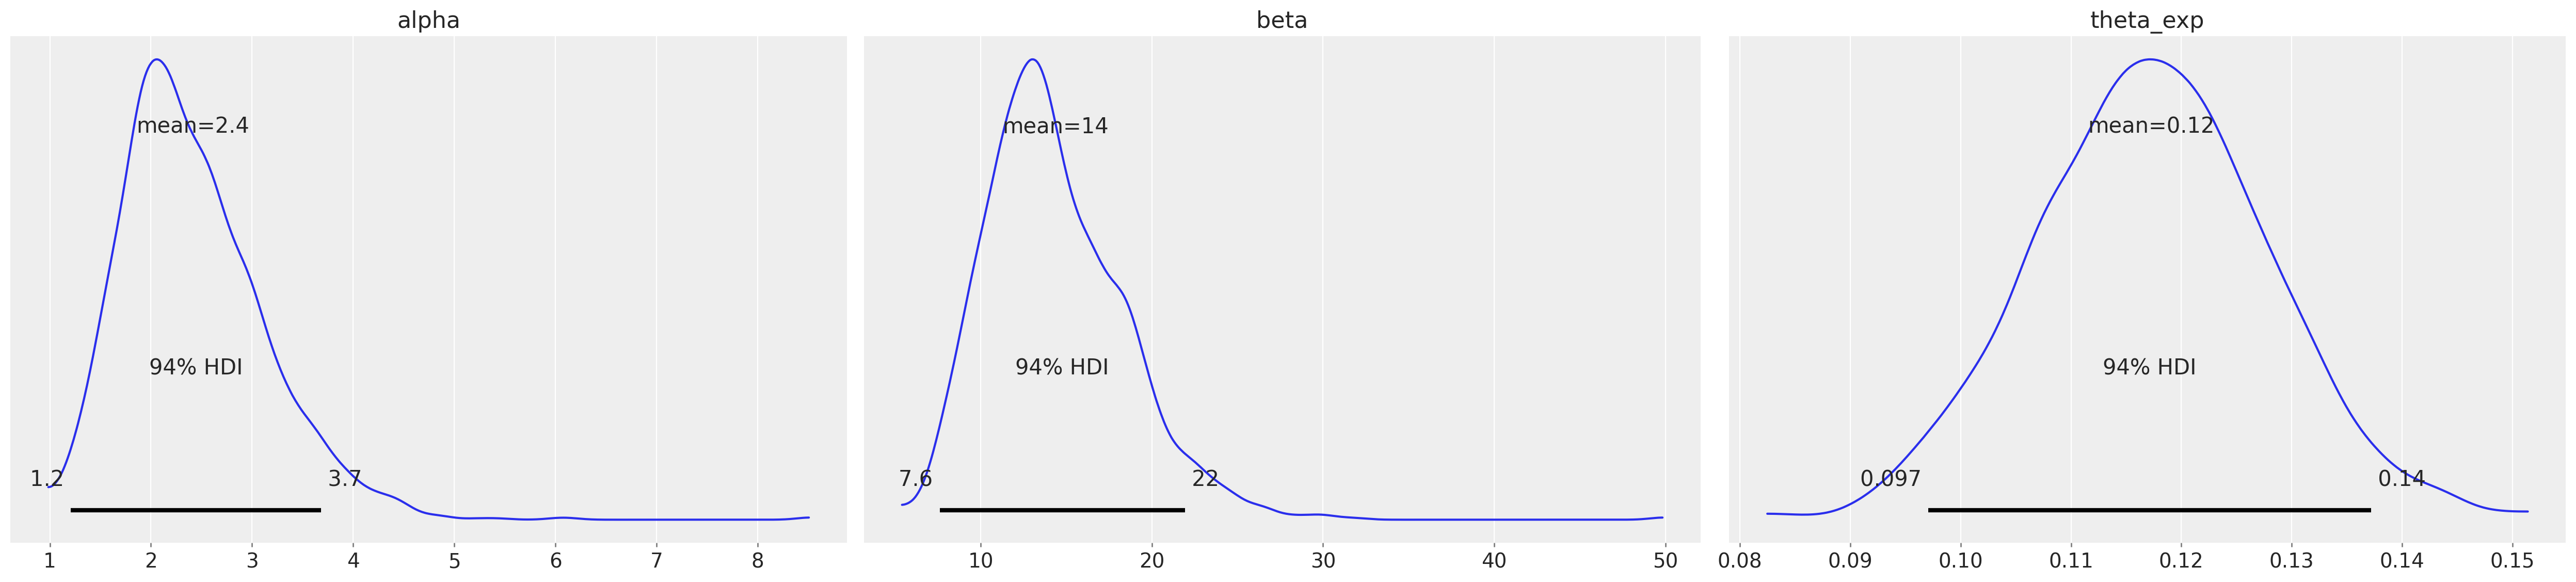

In [17]:
az.plot_posterior(trace_0, var_names=["alpha", "beta", "theta_exp"])

In [20]:
with pm.Model() as model_1:
    alpha_1 = pm.HalfNormal(name="alpha", sigma=10)
    beta_1 = pm.HalfNormal(name="beta", sigma=10)
    theta_1 = pm.Beta(name="theta", alpha=alpha_1, beta=beta_1)
    exp_1 = pm.Binomial(name="exp", p=theta_1, observed=tt.sum(y), n=tt.sum(n))
    trace_1 = pm.sample(draws=500, tune=500, target_accept=0.95, init="jitter+adapt_diag",
                        return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [21]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.235,1.983,0.192,6.817,0.070,0.050,733.0,1106.0,1.0
beta,11.949,6.459,0.943,23.317,0.224,0.158,760.0,980.0,1.0
theta,0.154,0.009,0.138,0.170,0.000,0.000,951.0,1013.0,1.0


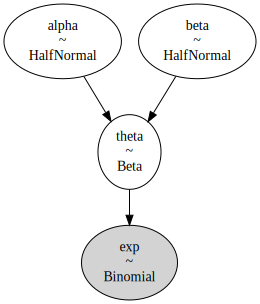

In [23]:
pm.model_to_graphviz(model_1)

In [29]:
2.17**trace_1.log_likelihood.exp.mean(("chain", "draw")).to_numpy()

array([0.04095964])

In [15]:
with pm.Model() as model_2:
    alpha_2 = pm.HalfNormal(name="alpha", sigma=10)
    beta_2 = pm.HalfNormal(name="beta", sigma=10)
    theta_2 = pm.BetaBinomial(name="theta", alpha=alpha_2, beta=beta_2, observed=tt.sum(y), n=tt.sum(n))
    trace_2 = pm.sample(draws=500, tune=500, target_accept=0.95, init="jitter+adapt_diag",
                        return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
az.summary(trace_2)
type(trace_2)

arviz.data.inference_data.InferenceData

array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'theta'}>], dtype=object)

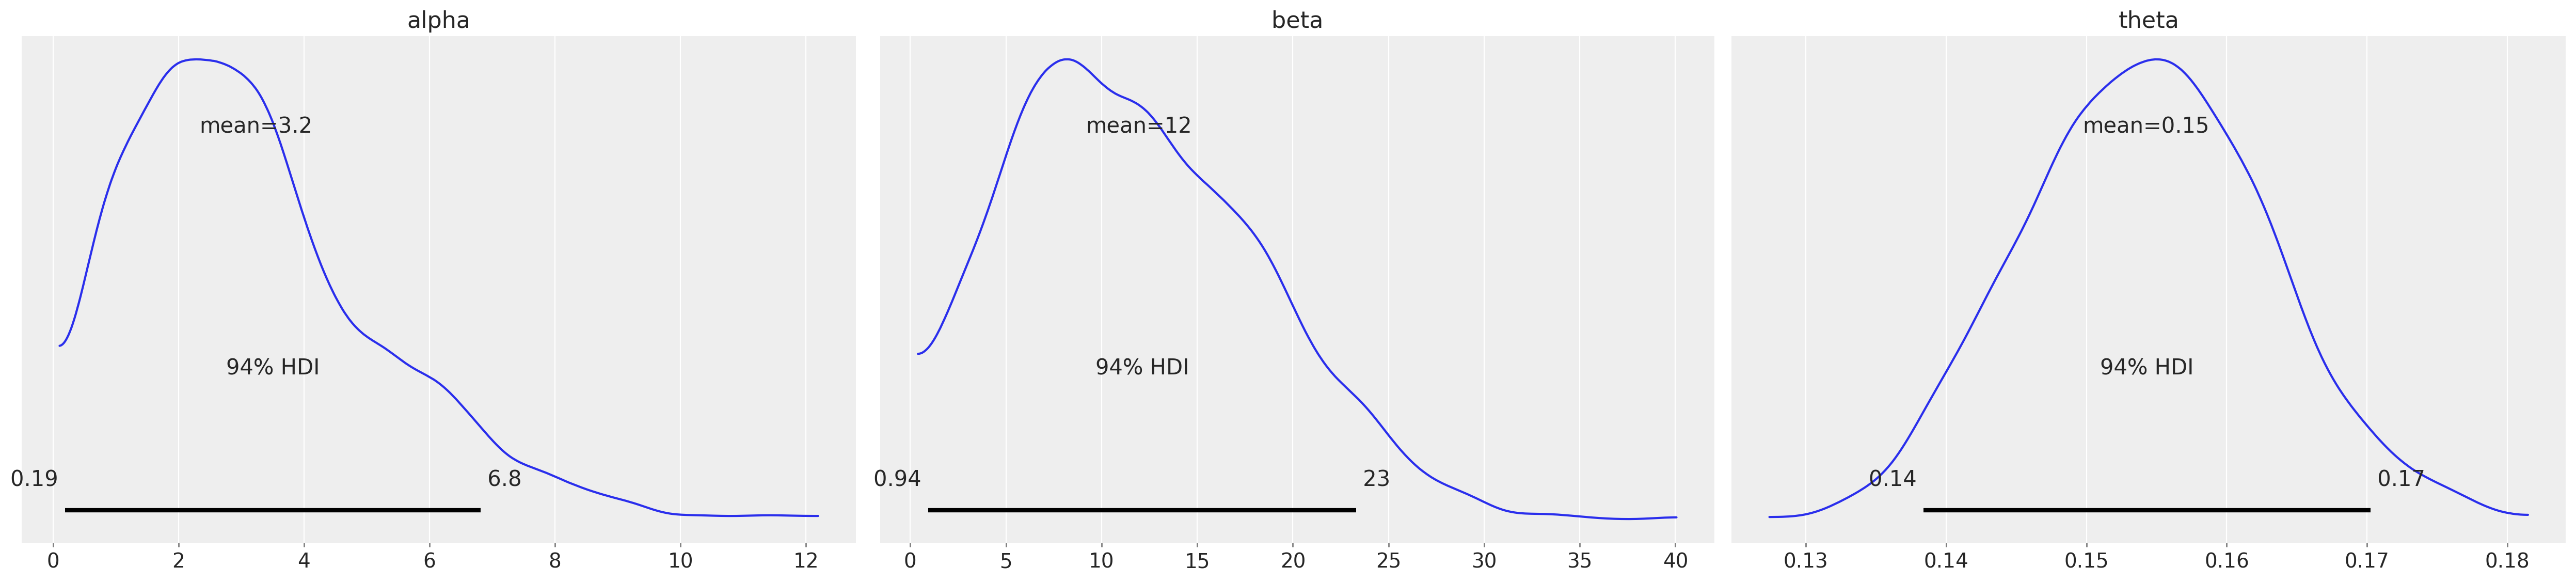

In [18]:
az.plot_posterior(trace_1, var_names=["alpha", "beta", "theta"])

In [41]:
def beta_binom(prior, k, n):
    """
    Compute the marginal likelihood, analytically, for a beta-binomial model.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    k : int
        Number of successful trails
    n : int
        Number of trails
    """
    alpha, beta = prior
    p_y = np.exp(betaln(alpha + k, beta + n - k) - betaln(alpha, beta))
    return p_y

In [46]:
priors = ((1, 1), (15, 14))
beta_binom((15, 14), 40, 100) / beta_binom((7.5, 7.5), 50, 100)

5.352053934483497

# Bayesian model selection

Bayes factors is a way to compare models to determine which ones are more likely and by how much:
$$
BF = \frac{p(y\mid M_0)}{p(y\mid M_1)}
$$
- 1-3: anecdotal
- 3-10: moderate
- 10-30: strong
- 30-100: very strong
- \>=100: extreme